# Tile Completion Metric

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The metric $\langle$zSNR$^2\rangle$ for a target class $C$ is defined in [DESI-4723](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=4723) as:
$$
\nu_C^2(t) = \sum_{k=\text{b,r,z}} \sum_\lambda \frac{
t^2 T_\text{target}^2 \langle \delta F^2\rangle}
{\sigma^2_\text{read} N_\text{pix} + t T_\text{sky} F_\text{sky}} \;,
$$
where:
 - $t$ is the exposure time in seconds,
 - $\langle \delta F^2\rangle$ is the ensemble average of $\left(F_i - \tilde{F}_i\right)^2$ over targets $i$ in the class, for noiseless target spectrum $F_i$ and its 100A median filtered $\tilde{F}_i$,
 - $F_\text{sky}$ is the assumed sky spectrum.
 - $T_\text{signal}$ converts the signal spectrum into detected electrons per second,
 - $T_\text{sky}$ converts the sky spectrum into detected electrons per second.

For the purposes of the API, we combine the instrumental variance per wavelength bin (assuming negligible dark current):
$$
\sigma^2 \equiv \sigma^2_\text{read} N_\text{pix}
$$
and decompose the signal conversion factor into
$$
T_\text{target} = f_{\text{dust},\lambda} \,f_{\text{atm},\lambda}\, A_{C,\lambda} T_{k,\lambda}
$$
where:
 - $f_\text{dust}$ is the extinction due to galactic dust which depends on the tile (ra,dec),
 - $f_\text{atm}$ is the extinction due to the atmosphere which depends on observing conditions (ETC),
 - $A$ is the fiber acceptance fraction, which depends on the target class and observing conditions (ETC),
 - $T$ is the remaining system throughput, which depends on the camera and is the same for signal and sky.

If we normalize $S \equiv F_\text{sky}$ to the detected sky flux over a nominal fiber area, then
$$
T_\text{sky} = T_{k,\lambda}
$$
and we can write (with explicit indices for the target class $C$, camera $k$ and wavelength $\lambda$):
$$
\nu_C^2(t) = \sum_{k=\text{b,r,z}} \sum_\lambda \frac{
t^2 f^2_{\text{dust},\lambda} \,f^2_{\text{atm},\lambda}\,
A_{C,\lambda}^2 T_{k,\lambda}^2 \langle \delta F^2\rangle_{C,\lambda}}
{\sigma^2_{k,\lambda} + t T_{k,\lambda} S_\lambda}
= t^2 \sum_\lambda f^2_{\text{dust},\lambda} \,f^2_{\text{atm},\lambda}\,
A_{C,\lambda}^2 \langle \delta F^2\rangle_{C,\lambda}
\sum_{k=\text{b,r,z}} \frac{T_{k,\lambda}^2}{\sigma^2_{k,\lambda} + t T_{k,\lambda} S_\lambda} \; .
$$

In [3]:
def get_target_sensitivity(target):
    """Get the tabulated sensitivity <dF**2> for the named target class.

    Sensitivity is defined as the ensemble average of F[i] - Fmed[i]
    over a representative sample of targets in the class, where
    F[i] is the expected number of photons entering a fiber per second,
    as a function of wavelength, and Fmed[i] is the result of applying
    a 100A median filter to F[i].

    Returns a cached value if this target class has already been loaded.

    Parameters
    ----------
    target : str
        One of the target class names predefined in desimodel.

    Returns
    -------
    tuple
        Tuple (wlen, dF2) of 1D arrays of the same length, with tabulated
        wavelengths in Angstrom and corresponding <dF**2> values.
    """
    wlen = 0.1 * np.arange(35500, 98501)
    
    # Use new code in desimodel.io here...
    dF2 = np.ones_like(wlen)
    
    return wlen, dF2

In [4]:
def get_instrument_sky_snr2(texp, throughput, readvar, skyflux):
    """Calculate the contribution to zSNR2 from throughput, read noise and sky.
    
    Input arrays must all be tabulated on the same wavlength grid,
    returned by :meth:`get_target_sensitivity`.
    
    Parameters
    ----------
    texp : float
        Exposure time in seconds.
    throughput : array
        2D array of shape (3, NW) of throughput values, excluding fiberloss,
        indexed by camera band (in the order b,r,z) and wavelength bin.
    readvar : array
        2D array of shape (3, NW) of read variances in electron ** 2 per wavelength bin,
        indexed by camera band (in the order b,r,z) and wavelength bin.
    skyflux : array
        1D array of shape (NW,) of sky fluxes defined as photons entering a
        fiber per second.
        
    Returns
    -------
    array
        1D array of length NW of tabulated values of T ** 2 / (rdvar + t T * S)
        summed over each camera band.
    """
    # When throughput is zero, the result is zero.
    ratio = np.divide(
        throughput ** 2, readvar + texp * throughput * skyflux,
        out=np.zeros_like(throughput), where=throughput > 0)
    return np.sum(ratio, axis=0)

In [5]:
def get_zSNR2(texp, target, throughput, readvar, skyflux, fiberloss, fdust=1, fatm=1):
    """Calcualte the zSNR2 metric of tile completion.
    
    See DESI-4723 for details.
    
    Input arrays must all be tabulated on the same wavlength grid,
    returned by :meth:`get_target_sensitivity`.
    
    Parameters
    ----------
    texp : float
        Exposure time in seconds.
    target : str
        One of the target class names predefined in desimodel.
    throughput : array
        2D array of shape (3, NW) of throughput values, excluding fiberloss,
        indexed by camera band (in the order b,r,z) and wavelength bin.
    readvar : array
        2D array of shape (3, NW) of read variances in electron ** 2 per wavelength bin,
        indexed by camera band (in the order b,r,z) and wavelength bin.
    skyflux : array
        1D array of shape (NW,) of sky fluxes defined as photons entering a
        fiber per second.
    fiberloss : array
        1D array of shape (NW,) of fiber acceptance fractions for the specified
        target class.
    fdust : float or array
        Dust extinction to apply. Can be a constant value or tabulated vs wavelength.
    fatm : float or array
        Atmospheric extinction to apply. Can be a constant value or tabulated vs wavelength.
        
    Returns
    -------
    float
        The value of zSNR2.
    """
    wlen, dF2 = get_target_sensitivity(target)
    ins_sky = get_instrument_sky_snr2(texp, throughput, readvar, skyflux)
    return texp ** 2 * np.sum((fdust * fatm * fiberloss) ** 2 * dF2 * ins_sky)

## Test with Specsim

In [6]:
import specsim.simulator
desisim = specsim.simulator.Simulator('desi', num_fibers=1)
desisim.simulate()

The nominal wavelength grid matches the one used internally by specsim:

In [7]:
wlen, dF2 = get_target_sensitivity('QSO')
np.allclose(wlen, desisim.simulated['wavelength'])

True

Extract the specsim throughput, read-noise variance, and sky flux:

In [8]:
throughput = np.stack([C.throughput for C in desisim.instrument.cameras])
readvar = np.stack([C.read_noise_per_bin.to('electron').value ** 2 for C in desisim.instrument.cameras])
skyflux = (
    desisim.atmosphere.surface_brightness *
    desisim.instrument.photons_per_bin *
    desisim.fiber_area).to('1/s').value

Calculate the instrument and sky contribution to zSNR2 for a 1000s exposure:

In [9]:
texp = 1000.
ins_sky = get_instrument_sky_snr2(texp, throughput, readvar, skyflux)

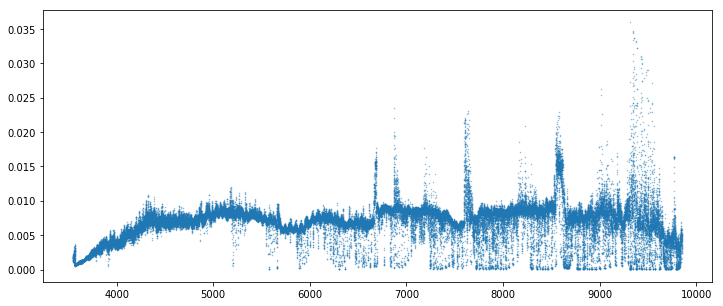

In [10]:
fig = plt.figure(figsize=(12, 5))
plt.plot(wlen, ins_sky, '.', ms=1, alpha=0.5);

Extract the specsim fiberloss:

In [11]:
fibernum = 0
fiberloss = np.array(desisim.simulated['fiberloss'])[fibernum]

Calculate zSNR2 (ignore the value since we are using dF2 = 1):

In [12]:
get_zSNR2(texp, 'QSO', throughput, readvar, skyflux, fiberloss)

96334156.47848043

## Open Issues

API above assumes that a standardized wavelength grid is used consistently for throughput, etc.  For example,
the specsim internal grid:

In [13]:
wlen

array([3550. , 3550.1, 3550.2, ..., 9849.8, 9849.9, 9850. ])

Is this sufficient or do we need more flexibility? (with additional validation and support for resampling)

We treat $\langle\delta F^2\rangle_{C,\lambda}$ as independent of the camera, but this is not strictly correct because they have different resolutions. We can finesse this using some average resolution, or just do it correctly.

Text(0, 0.5, 'FWHM Resolution [A]')

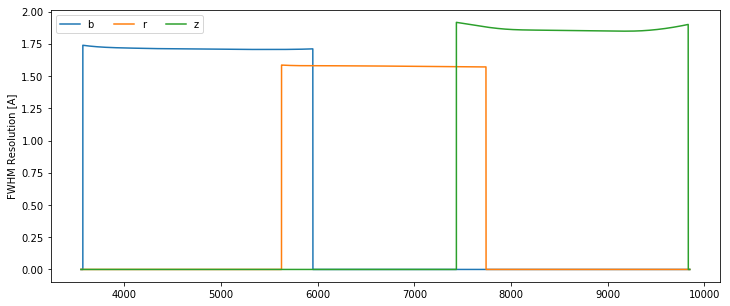

In [14]:
fig = plt.figure(figsize=(12, 5))
for camera in desisim.instrument.cameras:
    plt.plot(wlen, camera._fwhm_resolution, label=camera.name)
plt.legend(ncol=3)
plt.ylabel('FWHM Resolution [A]')

The ETC measures the fiberloss of a point source (using GFA stars), but this is not the same as the fiberloss $A_{C,\lambda}$ above for extended sources.

If we assume a nominal size galaxy size for each target class, the correction is straightforward.  However, since galaxy size is correlated with redshift, doing this correctly changes the weights of the ensemble average in $\langle\delta F^2\rangle$.

A good compromise is to tabulate $\langle\delta F^2\rangle_{C,\lambda}$ for a few different simulated seeing values, for each target class $C$, then interpolate to the ETC measured seeing.